#Required Imports

In [ ]:
import scipy.optimize 
import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sns
import matplotlib.dates as mdates
import sys
import numpy as np
import pandas as pd
import random
from datetime import datetime
import os
import pickle
from multiprocessing import Pool

In [ ]:
np.random.seed(42)

#Introduction
Francesco Mangia (francesco.mangia.97@gmail.com)


In this Document I will implement the strategy described in the paper "*High-Frequency Trading in a Limit Order Book*" (
https://www.math.nyu.edu/~avellane/HighFrequencyTrading.pdf) by Avellaneda and Stoikov. The strategy will be implemented and backtested for BTCUSD and ADAUSD, coins for which I was able to obtain the data related to the orderbook.

Despite the libraries available (Hummingbot, Bitmex sample market maker, etc), I opted for a naive implementation of the strategy, for reasons of reproducibility and configurability.

To implement the strategy, I relied on the implementation described in the Github Repository  quoted in *sources*, studying it and re-proposing it for the XBTUSD (BTC) and ADAUSD pairs.

Although during the week provided to complete the assignment there was no time to investigate the subject furtherly in order to implement a concrete model, I noticed how the state of the art of artificial intelligence offers a series of solutions consistent with the market making problem.

First of all, having already experimented with the implementations of Reinforcement and Deep Reinforcement Learning algorithms in the financial field, it occurred to me how a solution of this type can outperform the classic deterministic algorithms. The papers "*Reinforcement Learning Approaches to Optimal Market Making*" and "*OPTIMAL MARKET MAKING BY REINFORCEMENT LEARNING*" (https://www.mdpi.com/2227-7390/9/21/2689/pdf , https://arxiv.org/pdf/2104.04036.pdf) demonstrate the ability of a Reinforcement Learning agent, when rewarder properly, to find a delicate balance between the price risk of her inventory and the profits obtained by capturing the bid-ask spread.

Another possibility concerns the forecasting of market volatility to estimate the gamma parameter. In fact, estimating the parameter on the basis of a forecast of future volatility instead of the current market structure would benefit the strategy in terms of inventory management. Lately I have been working on paper from 2020, published by Google, namely "*Temporal Fusion Transformers for Interpretable Multi-horizon Time Series Forecasting*" (https://arxiv.org/abs/1912.09363), which demonstrates how complex structures such as Transformers are, at the state of the art, the most effective solutions for predicting future volatility of markets.

Even simpler models that exploit classification and forecasting algorithms through classic Machine Learning approaches have been exploited to support risk-management linked to market making strategies (https://web.stanford.edu/class/msande448/2017/Final/Reports/gr4.pdf).

## Sources



* https://quant.stackexchange.com/questions/36400/avellaneda-stoikov-market-making-model
* https://www.jstor.org/stable/2327382
* https://www.sciencedirect.com/science/article/abs/pii/S1386418113000207
* https://arxiv.org/pdf/1105.3115.pdf
* https://quant.stackexchange.com/questions/36073/how-does-one-calibrate-lambda-in-a-avellaneda-stoikov-market-making-problem
* https://github.com/lkrenn/Market-Making-With-Crypto
* https://arxiv.org/abs/1605.01862
* https://arxiv.org/abs/2112.02269
* https://arxiv.org/abs/2106.06974
* https://hummingbot.io/en/blog/2021-04-avellaneda-stoikov-market-making-strategy


## Avellaneda & Stoikov's Paper

Avellaneda and Stoikov's paper study the optimal submission strategies of bid and ask
orders in a limit order book, "*balancing between
the dealer’s personal risk considerations and the market
environment*" and defining the bid/ask spread as:

$$
\text{bid / ask spread} = \gamma \sigma ^2 (T - t) + \frac{2}{\gamma}\ln\left(1 + \frac{\gamma}{k}\right)
$$

This spread is defined around a reservation price i.e. a price at which a market maker is indifferent between their current portfolio and their current portfolio $\pm$ a new share. The reservation price is derived in the whitepaper as follows:

$$
\text{reservation price} = s - q\gamma\sigma^2(T-t)
$$

Where:

* $\gamma$, a risk factor that is adjusted to meet the risk/return trade-off of the market maker
* $x$, the initial capital of the market maker
* $k$, the intensity of the arrival of orders
* $s$ the per-unit mid-price of the asset
* $T$, the end of the time series
* $\sigma$, the volatility of the asset
* $q$, the number of assets held in inventory


# Strategy simulation through a Brownian Motion generator




---


In this section we will replicate the simulation carried out on the official paper to evaluate the performances of the strategy. The mid-price will be simulated as a Brownian Motion.


---



In [ ]:
# Create a brownian motion generator
def brownianMotion(x0, n, dt, sigma):
    # Generate normal random variables
    r = np.random.normal(size = n, scale = sigma*np.sqrt(dt))
    # Calculate cumulative sum of random variables
    cumsum = np.cumsum(r)
    # Add in initial conditions
    cumsum += np.expand_dims(x0, axis=-1)
    cumsum[0] = x0
    return cumsum

In [ ]:
#Parameters
s0 = 100
T = 1
sigma = 2
dt = 0.005
gamma = 0.1
k = 1.5
A = 140

In [ ]:
#Number of simulations
sim_length = 1000

In [ ]:
spreadlist = []
reslist = []
qlist = []

# Duration of each simulation
N = 200

for sim in range(sim_length):
    #Generate the Brownian Motion
    s = brownianMotion(s0, N+1, dt, sigma)
    # Initialize empty array for pnl
    pnl = np.zeros(N+2)
    # Inventory
    q = np.zeros(N+2)
    # Capital/Cash
    x = np.zeros(N+2)
    # Ask limit order
    s_a = np.zeros(N+1)
    # Reserve price
    r = np.zeros(N+1)
    # Bid limit order
    s_b = np.zeros(N+1)

    for i in range(len(s)):
        # Calculate reservation price
        r[i] = s[i] - q[i] * gamma * sigma**2 * (T-i*dt)
        # Calculate spread
        spread = gamma * sigma**2 * (T - i * dt) + (2 / gamma) * np.log(1 + (gamma / k))
        spread = spread / 2

        # Adjust spreads for gap between reserve price
        # and asset mid-price
        gap = np.abs(r[i] - s[i])

        if r[i] >= s[i]:
            delta_a = spread + gap
            delta_b = spread - gap
        else:
            delta_a = spread - gap
            delta_b = spread + gap

        s_a[i] = s[i] + delta_a
        s_b[i] = s[i] - delta_b

        # Calculate our lambdas, (12)
        lambda_a = A*np.exp(-k*delta_a) * dt
        lambda_b = A*np.exp(-k*delta_b) * dt

        # Restrict to domain of real probabilities
        # i.e. [0,1]
        prob_ask = max(0, min(lambda_a,1))
        prob_bid = max(0, min(lambda_b,1))

        # Determine whether or not we buy/sell according
        # to the above probabilities
        sell = np.random.choice([1,0], p=[prob_ask, 1-prob_ask])
        buy  = np.random.choice([1,0], p=[prob_bid, 1-prob_bid])

        # Adjust inventory to reflect transactions
        q[i+1] = q[i] + buy - sell

        # Calculate new capital
        x[i+1] = x[i] + sell*(s[i]+delta_a) - buy*(s[i]-delta_b)

        # Calculate pnl of assets
        pnl[i+1] = x[i+1] + q[i+1]*s[i]

        # Append results to lists
        spreadlist.append(spread * 2)

    reslist.append(pnl[-1])
    qlist.append(q[-1])


Let's compare the results obtained on the paper with those of our simulation to verify that it everything is implemented correctly:

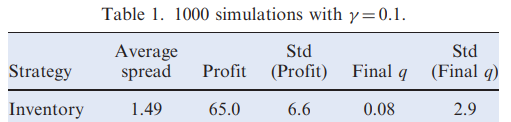


In [ ]:
pd.DataFrame([np.mean(spreadlist), np.mean(reslist), np.std(reslist), np.mean(qlist), np.std(qlist)],
            index=['Avg. Spread','Profit','Std (Profit)', 'Final $q$', 'Std (Final $q$)'],
            columns=['Inventory']).T

,Avg. Spread,Profit,Std (Profit),Final $q$,Std (Final $q$)
Inventory,1.49077,65.315004,6.628653,-0.031,3.021264




---


The results are consistent with what is described in the paper.
Now let's compare the distribution of the PnL obtained in our simulation with that published in the official paper (*i.e Inventory Strategy*)


---




/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


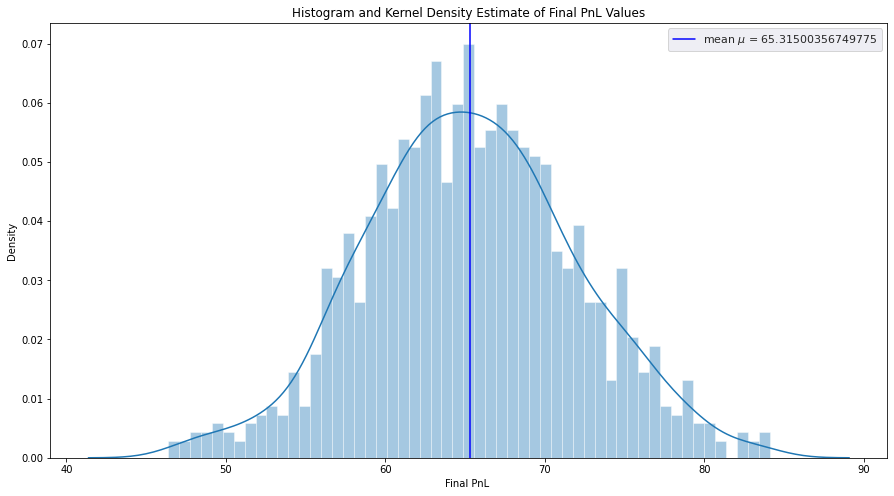

In [ ]:
plt.figure(figsize=(15,8))
plt.title('Histogram and Kernel Density Estimate of Final PnL Values')
# Set plot style
sns.set()
# Plot kernel density estimate with normalized histogram
sns.distplot(reslist,bins=55)
plt.axvline(x=np.mean(reslist),
            color='blue', label='mean $\mu$ = '+str(np.mean(reslist)))
plt.legend()
plt.ylabel('Density')
plt.xlabel('Final PnL ')
plt.show()

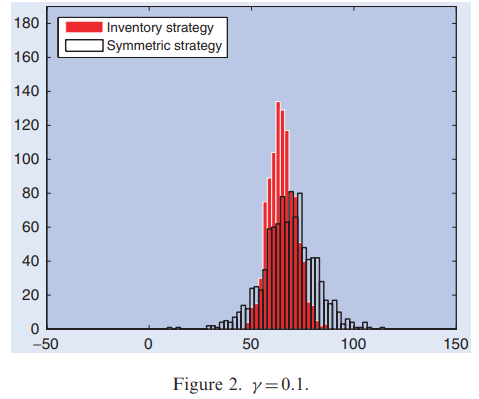



---


The distributions are similar and both are Gaussian with the mean close to 65 and a notable skew, proof that the strategy is implemented correctly.
Following, I plot the density and distribution of the final inventories resulting from the simulations.


---






/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


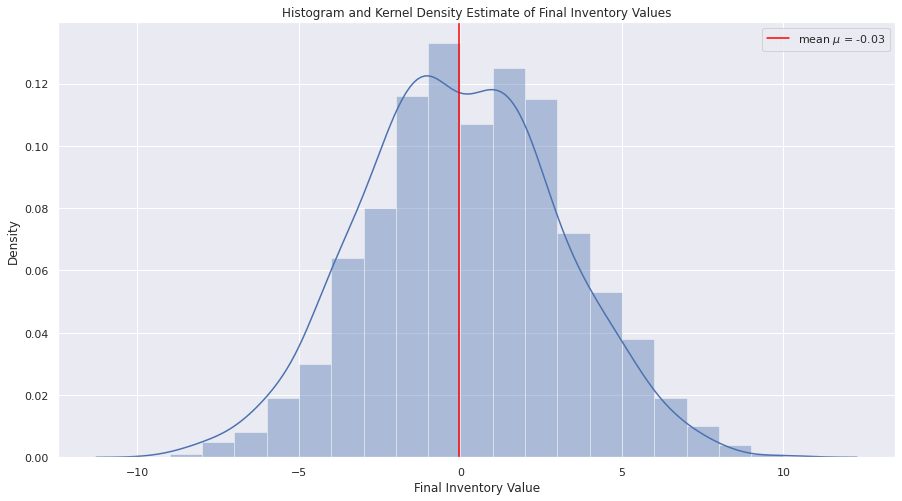

In [ ]:
plt.figure(figsize=(15,8))
plt.title('Histogram and Kernel Density Estimate of Final Inventory Values')
# Set plot style
sns.set()
# Plot kernel density estimate with normalized histogram
sns.distplot(qlist,bins=19)
plt.axvline(x=np.mean(qlist),
            color='red', label='mean $\mu$ = '+str(np.round(np.mean(qlist),2)))
plt.legend()
plt.ylabel('Density')
plt.xlabel('Final Inventory Value')
plt.show()



---


In the following graphs, instead , I plot the data relating to a single simulation of length N (the last one), in order to graphically display the information relating to the mid-price, the orders placed and those that have actually been filled. At the bottom instead, the inventory status at each timestep.

It is important to note that, following the implementation logic of the reservation price, the strategy favors buy or sell orders based on the inventory. In the event of positive inventory, in fact, the sell orders are placed closer to the mid-price and vice versa.


---





In [ ]:
# Combine all our results into a single DataFrane
res = pd.DataFrame([s_a, s, s_b], index=['sell limit orders', 'mid price', 'buy limit orders']).T

res['sells']  = ((pd.Series(q).diff() < 0)[:-1] * s_a).replace(0,np.nan)
res['buys']   = ((pd.Series(q).diff() > 0)[:-1] * s_b).replace(0,np.nan)


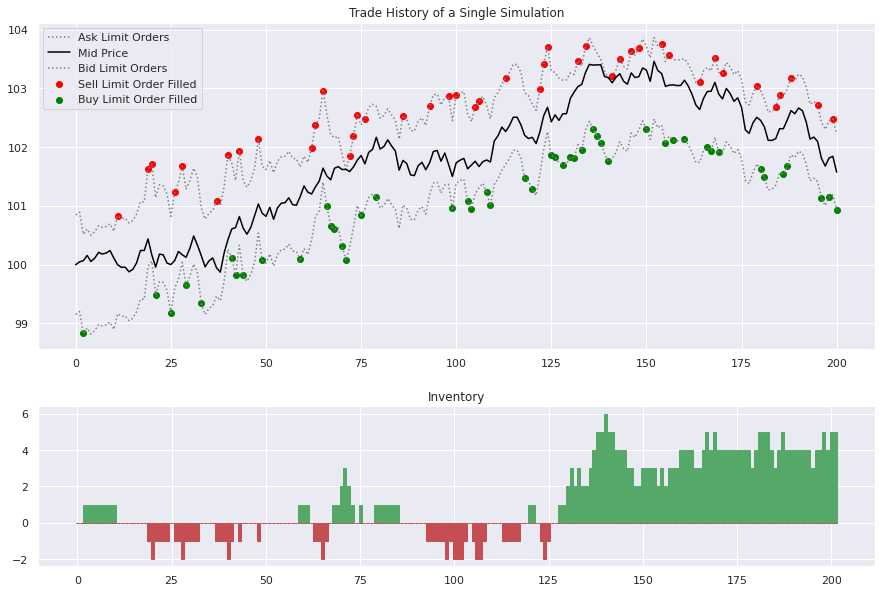

In [ ]:
fig = plt.figure(figsize=(15,10))

spec = gridspec.GridSpec(ncols=1, nrows=2, wspace=0.5,
                         hspace=0.5, height_ratios=[3, 1])

fig.add_subplot(spec[0])
# Plot limit orders and mid price
plt.plot(res.iloc[:,0], color='grey',  label='Ask Limit Orders', ls=':')
plt.plot(res.iloc[:,1], color='black', label='Mid Price')
plt.plot(res.iloc[:,2], color='grey',  label='Bid Limit Orders', ls=':')
# Add buys and sells
plt.scatter(range(201), res.iloc[:,3], color='red', label='Sell Limit Order Filled')
plt.scatter(range(201), res.iloc[:,4], color='green', label='Buy Limit Order Filled')
plt.legend()
plt.title('Trade History of a Single Simulation')
fig.add_subplot(spec[1])
plt.subplot(3,1,3)
plt.bar(range(len(q)), q*(q>0), color='g', edgecolor='g')
plt.bar(range(len(q)), q*(q<0), color='r', edgecolor='r')
plt.title('Inventory')
plt.show()

# Bitcoin Simulation Dataset


In this section I will proceed with a backtest of the strategy proposed in the Avellaneda and Stoikov's paper on Bitcoin.



## Historical Price Data



---


The historical price data used to carry out the backtest was downloaded by Kraken through the link provided in the assignment track. The CVS file is formatted as:
*   Date (UNIX format)
*   Asset Price
*   Volume Exchanged


---



In [ ]:
!wget -q --show-progress --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1gB_dLWVq_IaSBLU03spuynmWr2ZDtJe4' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1gB_dLWVq_IaSBLU03spuynmWr2ZDtJe4" -O BTCUSD.zip && rm -rf /tmp/cookies.txt


BTCUSD.zip          100%[===================>] 854.29M   213MB/s    in 4.3s    


In [ ]:
!unzip BTCUSD.zip

Archive:  BTCUSD.zip
  inflating: XBTAUD.csv              
  inflating: XBTCAD.csv              
  inflating: XBTCHF.csv              
  inflating: XBTDAI.csv              
  inflating: XBTEUR.csv              
  inflating: XBTGBP.csv              
  inflating: XBTJPY.csv              
  inflating: XBTUSD.csv              
  inflating: XBTUSDC.csv             
  inflating: XBTUSDT.csv             


In [ ]:
temp = pd.read_csv('XBTUSD.csv', header=None)
temp.columns = ['Timestamp', 'Price', 'Volume']
temp['Timestamp'] = pd.to_datetime(temp['Timestamp'], unit='s')
temp.head()

,Timestamp,Price,Volume
0,2013-10-06 21:34:15,122.00,0.1000
1,2013-10-07 20:50:30,123.61,0.1000
2,2013-10-08 02:58:35,123.91,1.0000
3,2013-10-08 02:58:35,123.90,0.9916
4,2013-10-08 05:26:44,124.19,1.0000


In [ ]:
temp = temp.set_index('Timestamp')

## Orderbook Data

As for the dataset related to the orderbook, I found it on this Kaggle repository:
https://www.kaggle.com/datasets/martinsn/high-frequency-crypto-limit-order-book-data?resource=download&select=ADA_1sec.csv
The dataset was uploaded to the drive to make the code easily re-executable.

In [ ]:
!wget -q --show-progress --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1XFdxPmewqqs5Nwxz7rUtnIGq8_LyclFg' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1XFdxPmewqqs5Nwxz7rUtnIGq8_LyclFg" -O BTCBook.zip && rm -rf /tmp/cookies.txt


BTCBook.zip         100%[===================>] 316.93M   212MB/s    in 1.5s    


In [ ]:
!unzip BTCBook.zip

Archive:  BTCBook.zip
  inflating: BTC_1sec.csv            


In [ ]:
BTC_mid = pd.read_csv('BTC_1sec.csv')
BTC_mid.head()

,Unnamed: 0,system_time,midpoint,spread,buys,sells,bids_distance_0,bids_distance_1,bids_distance_2,bids_distance_3,...,asks_market_notional_5,asks_market_notional_6,asks_market_notional_7,asks_market_notional_8,asks_market_notional_9,asks_market_notional_10,asks_market_notional_11,asks_market_notional_12,asks_market_notional_13,asks_market_notional_14
0,0,2021-04-07 11:32:42.122161+00:00,56035.995,0.01,0.0,0.0,-8.922836e-08,-2.676851e-07,-0.00005,-0.000245,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,2021-04-07 11:32:43.122161+00:00,56035.995,0.01,0.0,0.0,-8.922836e-08,-2.676851e-07,-0.00005,-0.000245,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,2021-04-07 11:32:44.122161+00:00,56035.995,0.01,0.0,0.0,-8.922836e-08,-2.676851e-07,-0.00005,-0.000245,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,2021-04-07 11:32:45.122161+00:00,56035.995,0.01,0.0,0.0,-8.922836e-08,-2.676851e-07,-0.00005,-0.000245,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,2021-04-07 11:32:46.122161+00:00,56035.995,0.01,0.0,0.0,-8.922836e-08,-2.676851e-07,-0.00005,-0.000245,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0



For this simulation, we will only need the "*system_time*" and "*midpoint*" columns. The remaining columns have then been dropped.
In addition, although I recognize that in real operation the maximum granularity of the data is preferred,for the sake of this assignment to align the dataset to the Kraken dataset, I have removed the milliseconds.

In [ ]:
BTC_mid['system_time'] = pd.to_datetime(BTC_mid['system_time'])
BTC_mid = BTC_mid.loc[:,['system_time', 'midpoint']]

list_of_dates = BTC_mid['system_time'].dt.date.unique().tolist()

BTC_mid = BTC_mid.set_index('system_time')
BTC_mid.index = pd.to_datetime(BTC_mid.index.strftime('%Y-%m-%d %H:%M:%S'))
BTC_mid = BTC_mid.resample('S').ffill()
BTC_mid.head()

,midpoint
system_time,
2021-04-07 11:32:42,56035.995
2021-04-07 11:32:43,56035.995
2021-04-07 11:32:44,56035.995
2021-04-07 11:32:45,56035.995
2021-04-07 11:32:46,56035.995


# Implementation of Avellaneda-Stoikov's Strategy to Bitcoin Data

In this backtest we will use real market data to evaluate the performance of the avellaneda-stoikov strategy.
Given the limited time available, I will assume that:
*   All of the orders of size 1 get filled.
*   All our order gets filled first, and fully filled.



In [ ]:
def run_backtest(s, m, gamma, A, k, sigma):
    N = 60*60*24
    T = 1
    dt = T/N

    # Initialize empty array for pnl
    pnl = np.zeros(N+1)

    # Inventory
    q = np.zeros(N+1)

    # Capital
    x = np.zeros(N+1)

    # Spread
    spr = np.zeros(N+1)

    # Ask limit orders
    r_a = np.zeros(N+1)

    # Reserve price
    r = np.zeros(N+1)

    # Bid limit orders
    r_b = np.zeros(N+1)

    # Get market orders for next day, low market is lowest
    # price of market order submitted in 1-sec
    low_mkt = m.resample('S').min().reindex(s.index)

    # hi market is highest price of market order submitted
    # in 1-sec
    hi_mkt = m.resample('S').max().reindex(s.index)

    # Iterate through each second
    for i in range(len(s)):

        # Find the date for the given iteration
        date = s.index[i]

        # Calculate our reservation price
        r[i] = s[i] - q[i] * gamma * sigma**2 * (T-i*dt)

        # Calculate our spread
        spread = gamma * sigma**2 * (T - i * dt) + (2 / gamma) * np.log(1 + (gamma / k))
        spr[i] = spread
        spread = spread / 2

        # Adjust spreads for gap between reserve price
        # and asset mid-price
        gap = np.abs(r[i] - s[i])

        # Define the distance between r[i] and our limit orders
        if r[i] >= s[i]:
            delta_a = spread + gap
            delta_b = spread - gap
        else:
            delta_a = spread - gap
            delta_b = spread + gap

        # Define our limit orders
        r_a[i] = r[i] + delta_a
        r_b[i] = r[i] - delta_b

        # Do not buy or sell unless we get a feasible market order
        sell = 0
        buy  = 0

        # If a market order is higher than our ask price, sell 1 unit
        if hi_mkt.loc[:,'Price'].values[i] > r_a[i]:
            sell = 1

        # If a market order is lower than our bid price, buy 1 unit
        if low_mkt.loc[:,'Price'].values[i] < r_b[i]:
            buy = 1

        # Adjust inventory to reflect transactions
        q[i+1] = q[i] + buy - sell

        #     # Calculate new capital
        x[i+1] = x[i] + sell*(s[i]+delta_a) - buy*(s[i]-delta_b)

        #     # Calculate pnl of assets
        pnl[i+1] = x[i+1] + q[i+1]*s[i]

    return {'pnl':pnl, 'x':x, 'q':q, 'spread':spr, 'r':r, 'r_a':r_a, 'r_b':r_b}

## Parameters estimation - Volatility σ:

One of the most important measures of an asset is its volatility. Under the assumptions of the model, $\sigma$ is the diffusion factor of a Brownian Motion. Therefore, once we are given price data, we can develop a naive estimate of an asset's $\sigma$ by calculating the standard deviation of the previous days' price movements.  we use log-returns to calculate volatility i.e.

$$
\begin{aligned}
\text{Log Return} &= \ln\left(\frac{p_t}{p_{t-1}}\right) = \ln\left(p_t\right) - \ln\left(p_{t-1}\right)\\
\\
\Rightarrow \sigma &= \frac{\sqrt{\sum\ln^2 \left(\frac{S_{i+1}}{S_i}\right)}}{\sqrt{N-1}} \sqrt{60\cdot60\cdot24}\\
\end{aligned}
$$


In order to smooth the process and remove outliers, I will compute a 7-days moving average.

In [ ]:
# Calculate the stds
std = (np.log(temp.loc[:,'Price']).diff() # Difference the log prices
                                  .dropna() # Remove any NaNs
                                  .groupby(pd.Grouper(freq='1D')).std() # Calculate the std for each day
                                  .rolling('7D').mean()) # Compute the rolling 7-D average of these

# Scale accordingly
std = std * np.sqrt(60*60*24)
std

Timestamp
2013-10-07         NaN
2013-10-08    0.417870
2013-10-09    0.325551
2013-10-10    1.326991
2013-10-11    1.326991
                ...   
2022-03-27    0.036402
2022-03-28    0.033890
2022-03-29    0.030502
2022-03-30    0.029914
2022-03-31    0.028299
Freq: D, Name: Price, Length: 3098, dtype: float64

In [ ]:
sigmalist = [std[d.strftime('%Y-%m-%d')] for d in list_of_dates]
sigmalist

[0.029194138465388188,
 0.028631046439029778,
 0.028844249501970252,
 0.03063668959581363,
 0.030599255684546103,
 0.03133843124808907,
 0.03133920828034412,
 0.032494578873549874,
 0.03270284199324815,
 0.03243235492032015,
 0.029706283303584706,
 0.055184096382686926,
 0.05664132362241363]

## Parameters Estimation A and K:

At this point, I estimate the parameters A and k, responsible for describing the liquidity of the asset, where:
$$
\lambda(\delta) = A e^{-\kappa\delta}
$$

Sources:


*   "*Dealing with the Inventory Risk*" (https://arxiv.org/pdf/1105.3115.pdf)
*   https://quant.stackexchange.com/questions/36073/how-does-one-calibrate-lambda-in-a-avellaneda-stoikov-market-making-problem

The idea behind this estimation method is as follows:

1. Define a range of gaps from the mid price ($\delta$)
2. For each delta, place a limit buy/sell order at the asset mid price $\pm\delta$
3. Using the market data, calculate how long it takes for these limit orders to theoretically be filled ($\delta_t$)
4. Form a histogram of the $\delta_t$ for each $\delta$, they should form a nice exponential distribution
5. Calculate the empirical exponential parameter $\lambda$ for this distribution for each $\delta$
6. These $\lambda$ parameters themselves follow an exponential distribution--solve for the parameters of this distribution to get $A$, $k$


Assumptions:
* In our dataset there can be more than one market order in a one-second increment. Therefore, we can determine if an ask limit order is filled by considering the max market order that happened in a given one-second increment. This applies also to buy limit orders, but instead we consider the minimum order in a given one-second interval.




In [ ]:
deltalist = np.linspace(0.1,1,10)
# Define a function of the expnential curve we are trying to fit
def exp_fit(x,a,b):
    y = a*np.exp(-b*x)
    return y

In [ ]:
Alist = []
klist = []

for i in range(len(list_of_dates)-1):
    day = list_of_dates[i].strftime('%Y-%m-%d')
    print(day)

    sample = BTC_mid.loc[day]
    sample.index = pd.to_datetime(sample.index)

    mkt_sample = temp.loc[day][sample.index[0]:]['Price']

    deltadict = {}

    for price_delta in deltalist:
        sample['bid'] = sample['midpoint'] - price_delta
        sample['ask']  = sample['midpoint'] + price_delta

        bid_limit_order_hit = (mkt_sample.groupby(pd.Grouper(freq='1S'))
                                         .apply(lambda x: np.max(x) < sample.loc[x.name, 'bid']))


        ask_limit_order_hit = (mkt_sample.groupby(pd.Grouper(freq='1S'))
                                         .apply(lambda x: np.max(x) > sample.loc[x.name, 'ask']))

        # Combine the two into a single signal
        limit_order_hit = bid_limit_order_hit | ask_limit_order_hit

        deltas = pd.Series(limit_order_hit[limit_order_hit == 1].index).diff().apply(lambda x: x.total_seconds())

        deltadict[price_delta] = deltas

    lambdas = pd.DataFrame([[key,1/deltadict[key].mean()] for key in deltadict.keys()],
                       columns=['delta','lambda_delta']).set_index('delta')

    paramsB, cv = scipy.optimize.curve_fit(exp_fit, np.array(lambdas.index), np.array(lambdas['lambda_delta'].values))
    A, k = paramsB

    Alist.append(A)
    klist.append(k)

2021-04-07
2021-04-08
2021-04-09
2021-04-10
2021-04-11
2021-04-12
2021-04-13
2021-04-14
2021-04-15
2021-04-16
2021-04-17
2021-04-18


## Parameters Estimation $\gamma$

Now that the A and K parameters have been calculated, they can be used to backtest and optimize $\gamma$ in order to maximize the sharpe ratio. The $\gamma$ value that optimizes the sharpe at time t-1 will be used at time t. Perhaps, here I calculate the $\gamma$ for each day.

In [ ]:
# in parallel
def parallel_backtest(gamma):

    # Run the backtest
    res = run_backtest(s, m, gamma, A, k, sigma)

    # Calculate the percent change of PnL
    res_pnl = pd.Series(res['pnl']).pct_change().dropna()[1:]

    # Calculate the Sharpe of backtest
    return [gamma, res_pnl.mean() / res_pnl.std()]

In [ ]:
# Define number of processes
p = Pool(processes=20)

# Map the parallel_backtest function to each process,
# Define the gamma search space as 50 evenly-placed numbers
# between 0.1 and 5
data = p.map(parallel_backtest, np.linspace(0.1,5,50))

# End the processes
p.close()

In [ ]:
best_gamma = pd.DataFrame(data).set_index(0).idxmax().values[0]
best_gamma

2.6

In [ ]:
gammalist = []

# Skip a day because we need to use parameter estimates from
# day t-1 to calculate the PnL of t
for j in range(1,len(list_of_dates)):

    # Get parameters from previos day
    sigma = sigmalist[j-1]
    A = Alist[j-1]
    k = klist[j-1]

    date = list_of_dates[j].strftime('%Y-%m-%d')
    print(date)

    # Get mid prices for the day
    s = BTC_mid.loc[date]

    # Fill in any missing seconds with NaNs
    s = s.resample('S').asfreq(fill_value=np.nan)

    # Forward fill the previous midprice if one doesn't
    # exist for a given second-interval
    s = s.ffill()
    s = s['midpoint']

    m = temp.loc[date]

    # Get market orders for next day, low market is lowest
    # price of market order submitted in 1-sec
    low_mkt = m.resample('S').min().reindex(s.index)

    # hi market is highest price of market order submitted
    # in 1-sec
    hi_mkt = m.resample('S').max().reindex(s.index)

    p = Pool(processes=20)
    data = p.map(parallel_backtest, np.linspace(0.1,5,50))
    p.close()

    best_gamma = pd.DataFrame(data).set_index(0).idxmax().values[0]

    gammalist.append(best_gamma)

2021-04-08
2021-04-09
2021-04-10
2021-04-11
2021-04-12
2021-04-13
2021-04-14
2021-04-15
2021-04-16
2021-04-17
2021-04-18
2021-04-19


In [ ]:
gammalist

[2.6,
 3.7,
 1.2000000000000002,
 0.7000000000000001,
 3.4000000000000004,
 1.4000000000000001,
 3.4000000000000004,
 3.1,
 0.8,
 1.5000000000000002,
 1.7000000000000002,
 0.7000000000000001]

 # Full Backtest BTC (XBTUSD)


Now that all the parameters have been estimated, we can perform a complete backtest of the strategy on BTC.


In [ ]:
res = {}

# Exactly the same as before, just iterating through
# all the relevant days
for j in range(1,len(list_of_dates)-1):

    date = list_of_dates[j].strftime('%Y-%m-%d')
    s = BTC_mid.loc[date]

    # Fill in any missing seconds with NaNs
    s = s.resample('S').asfreq(fill_value=np.nan)

    # Forward fill the previous midprice if one doesn't
    # exist for a given second-interval
    s = s.ffill()
    s = s['midpoint']

    m = temp.loc[date]

    A = Alist[j-1]
    k = klist[j-1]
    sigma = sigmalist[j-1]
    gamma = gammalist[j-1]
    #print(gamma, A, k, sigma)

    res[date] = run_backtest(s, m, gamma, A, k, sigma)

Calculate cumulative PnL:

In [ ]:
#Cumulative PNL
for i in range(1,len(list_of_dates)-1):

    # Get both current day and previous day
    date = list_of_dates[i].strftime('%Y-%m-%d')
    prev_date = list_of_dates[i-1].strftime('%Y-%m-%d')

    # If first day, no addition needed
    if i == 1:
        res[date]['pnl'] = res[date]['pnl'][1:]

    # Else, add the terminal PnL of day t-1 to day t's PnL
    else:
        res[date]['pnl'] = res[date]['pnl'][1:]+res[prev_date]['pnl'][-1]

Plot the PnL curve:

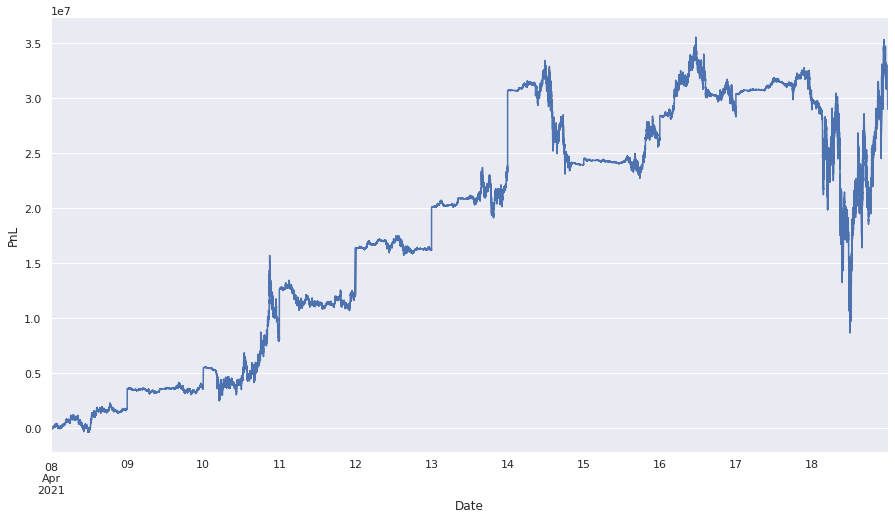

In [ ]:
# Plot the results
fig = plt.figure(figsize=(15,8))
#ax = fig.add_subplot(111)

# Concatenate into a single DataFrame
full_backtest_res = pd.concat([pd.Series(res[x]['pnl']) for x in res.keys()],
                              axis=0)

full_backtest_res.index = pd.to_datetime(BTC_mid['2021-04-08':'2021-04-18'][:-11].index)
full_backtest_res.plot()
plt.xlabel('Date')
plt.ylabel('PnL')
plt.show()

Let's now give a look at the inventory and spread related to the backtest. As also noted for the Cardano backtest (ADA), peaks in the inventory are associated with large movements also in the Pnl curve.
As for the spread, it does not seem that its value is time dependent.

In [ ]:
date_index = BTC_mid['2021-04-08':'2021-04-18'].index

In [ ]:
BTC_q = pd.concat([pd.Series(res[date]['q'][1:]) for date in res.keys()], axis=0)
BTC_q.index = date_index

In [ ]:
BTC_spread = pd.concat([pd.Series(res[date]['spread'][:-1]) for date in res.keys()], axis=0)
BTC_spread.index = date_index

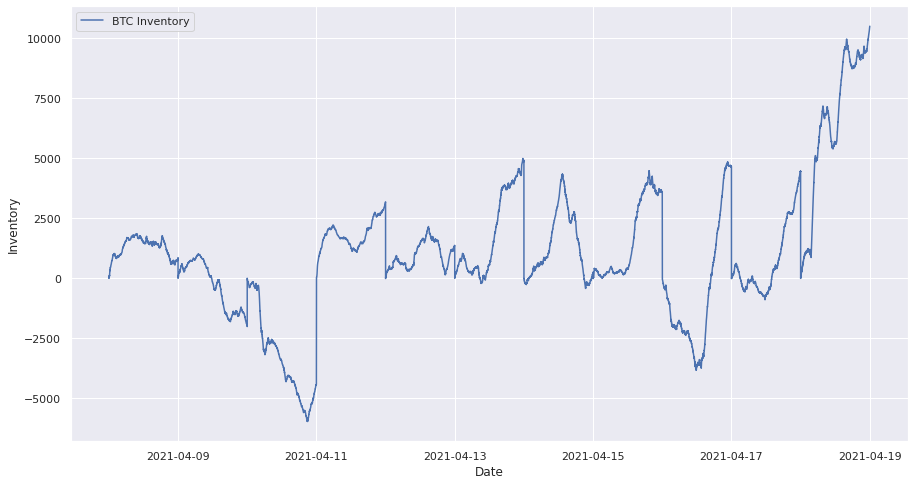

In [ ]:
# Plot the results
fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot(111)
plt.plot(BTC_q, label='BTC Inventory')
plt.xlabel('Date')
plt.ylabel('Inventory')
plt.legend()
plt.show()

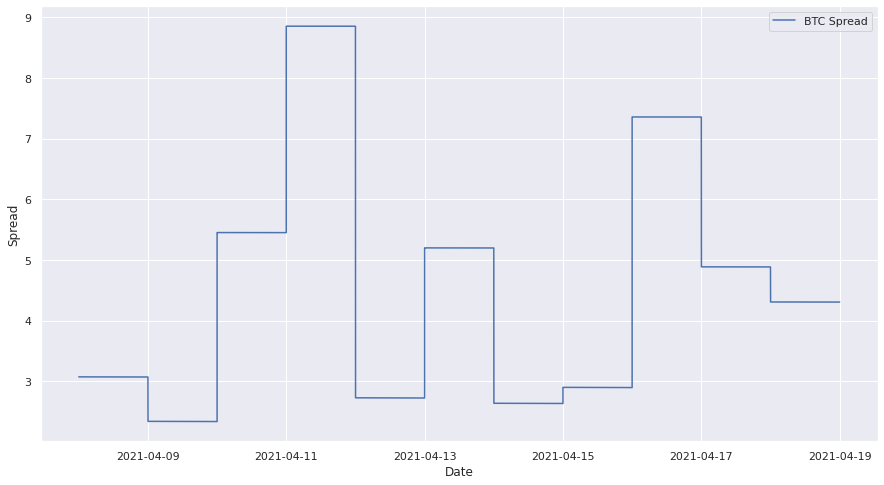

In [ ]:
# Plot the results
fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot(111)
plt.plot(BTC_spread, label='BTC Spread')
plt.xlabel('Date')
plt.ylabel('Spread')
plt.legend()
plt.show()